# TESS lightcurve quicklook

Let's spot check the lightcurves for the sources that have been observed as of March 18, 2021: 
- UCAC2 7201471
- TYC 8534-1243-1 
- HD 49855 
- V* V479 Car 
- V* V1249 Cen (two out of five)

### Get the IGRINS epoch times.

In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import lightkurve as lk
from astropy.time import Time
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df_log = pd.read_csv('../../data/IGRINS/2021A_metadata_log.csv')

In [4]:
df_log.tail()

,night_dir,OBJECT,EXPTIME,BTJD
11,20210216,HD 49855,4.0,2262.6009
12,20210216,TYC 8534-1243-1,80.0,2262.5276
13,20210216,UCAC2 7201471,30.0,2262.5426
14,20210217,HD 49855,20.0,2263.5394
15,20210221,UCAC2 7201471,30.0,2267.5131


In [5]:
df_log.OBJECT.value_counts()

UCAC2 7201471      6
TYC 8534-1243-1    5
HD 49855           5
Name: OBJECT, dtype: int64

Nice! At least 5 observations for all of these.  We don't have data from the most recent observing run yet, so we are missing log entries for:  
- V* V479 Car
- V* V1249 Cen (two out of five)

## TESS Lightcurves

In [6]:
btjd_now = Time.now().jd - 2457000.0
btjd_now

2292.6764361192472

### UCAC2 7201471

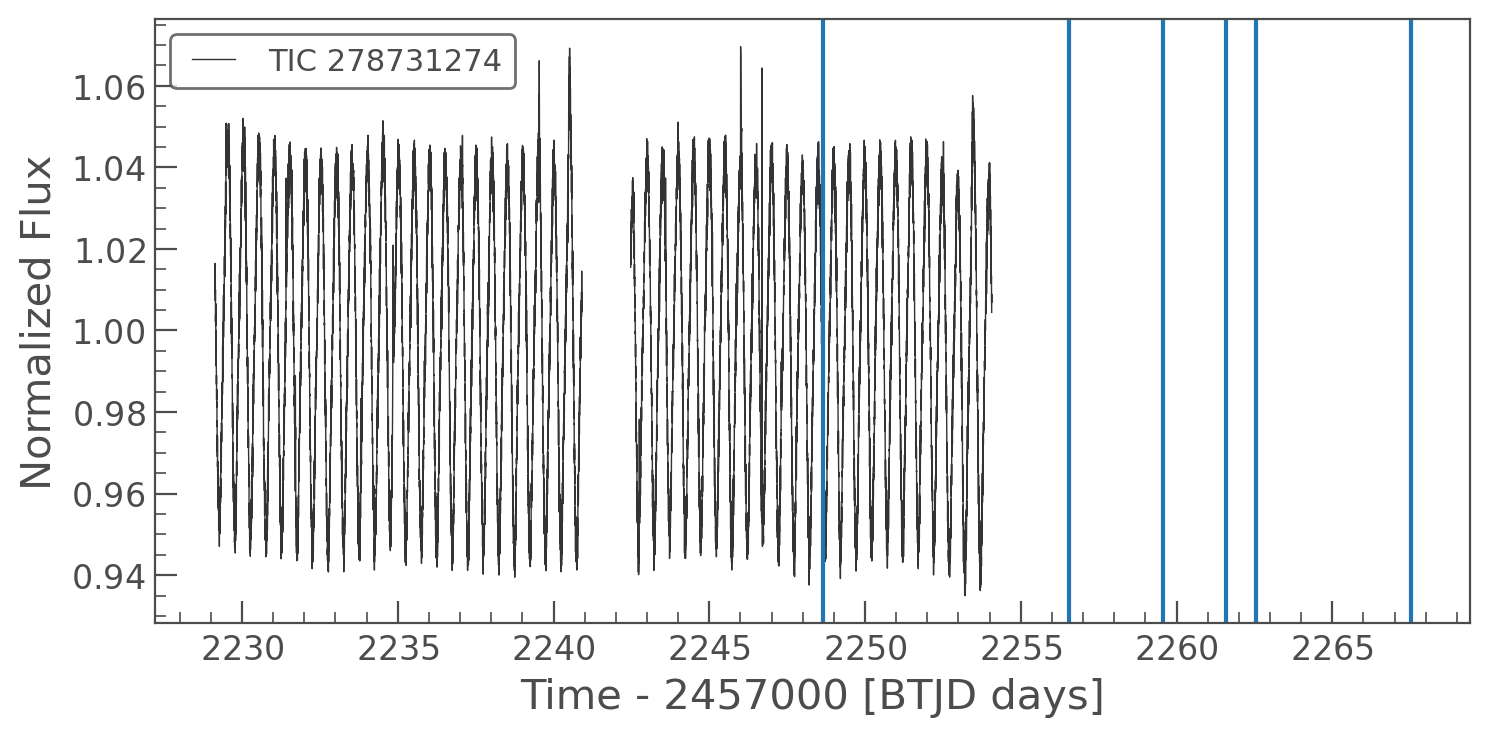

In [7]:
object_name = 'UCAC2 7201471'
sr = lk.search_lightcurve(object_name, sector='34')
lc = sr.download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot();
for epoch in epochs:
    ax.axvline(epoch)

### TYC 8534-1243-1

In [8]:
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 34,2021,SPOC,120,278731274,0.0


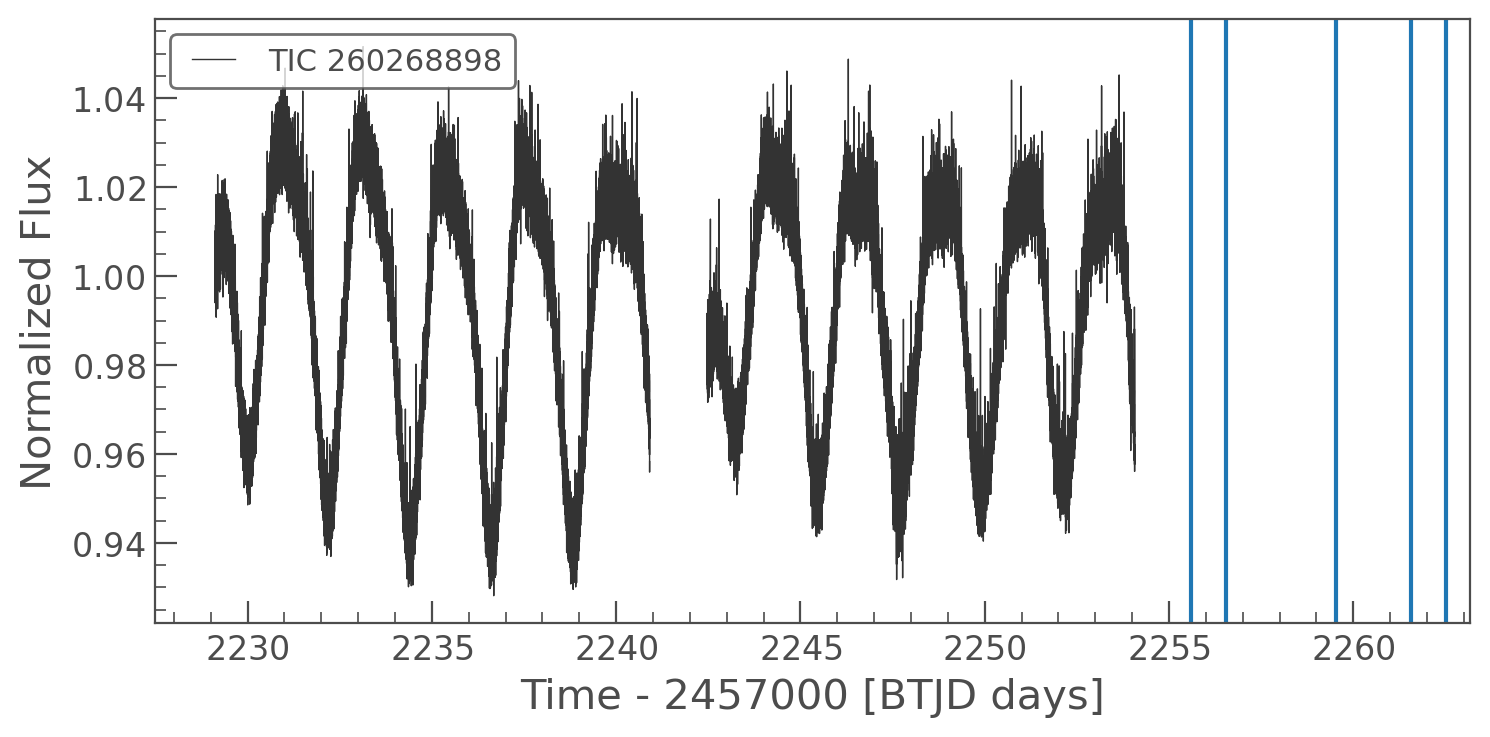

In [9]:
object_name = 'TYC 8534-1243-1'
sr = lk.search_lightcurve(object_name, sector='34', exptime=20)
lc = sr.download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot();
for epoch in epochs:
    ax.axvline(epoch)

### HD 49855  

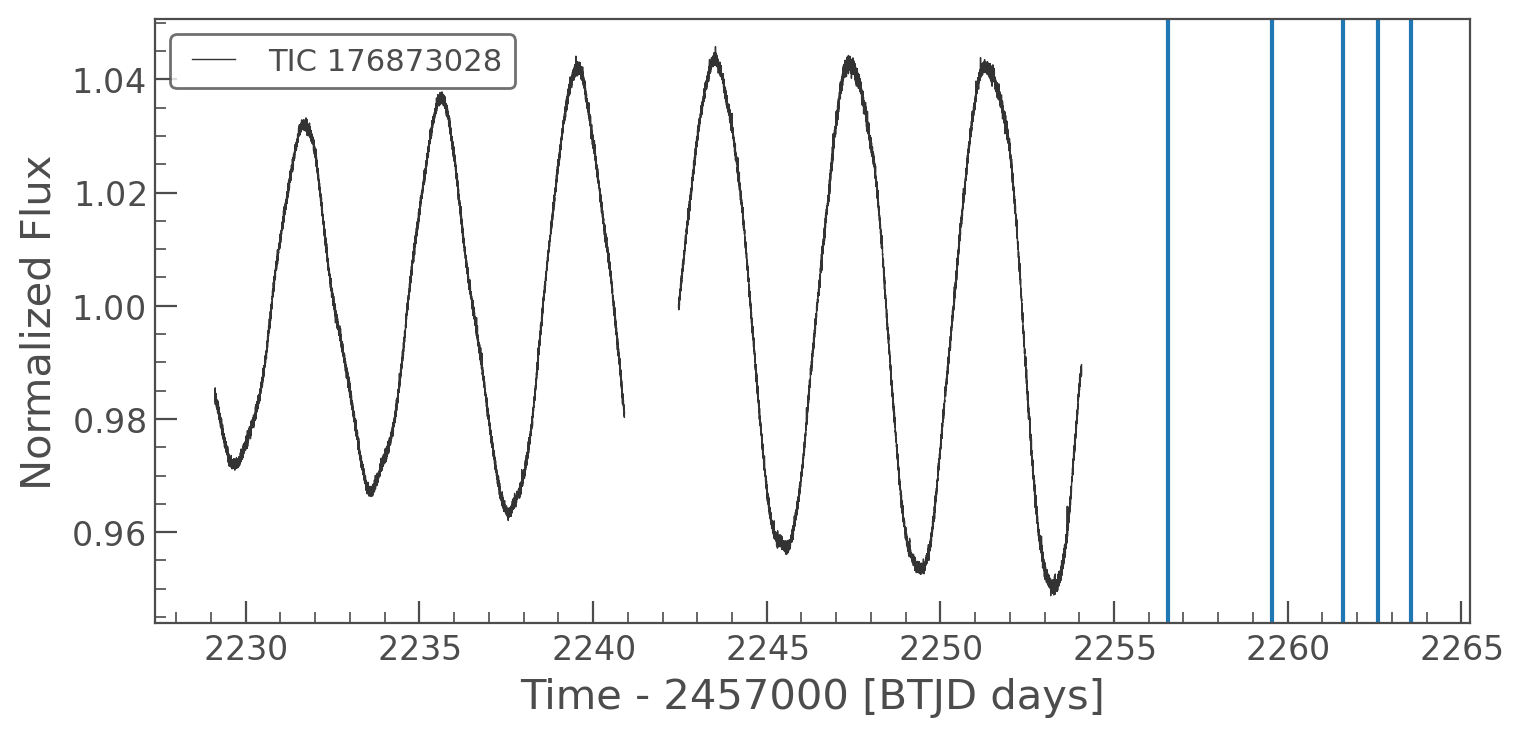

In [10]:
object_name = 'HD 49855'
sr = lk.search_lightcurve(object_name, sector='34', exptime=120)
lc = sr.download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot();
for epoch in epochs:
    ax.axvline(epoch)

## Early Release data products

TICA now offers [early release data products](https://heasarc.gsfc.nasa.gov/docs/tess/a-beta-trial-of-quick-look-tess-orbit-data-early-release-of-sector-35-orbit-1-calibrated-full-frame-images.html) through TICA full frame images.

There are two ways to try to access TICA:

- With tess-cloud, vis-a-vis the demo on [this GitHub Issue](https://github.com/lightkurve/lightkurve/issues/993)
- Download the full FFI frames yourself from the [TICA curl scripts](https://archive.stsci.edu/hlsp/tica)

Both of these strategies are not well-proven!  Let's use `tess-point` to get the coordinates.

### HD 49855

`python -m tess_stars2px -t 176873028`


|Sector | Camera | Ccd | ColPix | RowPix | EdgeWarn|
|--|--|--|--|--|--|
|35 | 4 | 1 | 1018.113608 | 2009.703572 | 0|

In [11]:
from astropy.io import fits
import glob
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np
import tqdm

In [12]:
lc.ticid

176873028

Ok, so we want camera 4, ccd 1.

In [13]:
tica_fns = glob.glob('../../data/TESS/TICA/s0035/cam4-ccd1/*.fits')

In [14]:
len(tica_fns)

1712

Get a preliminary image to set the mask

In [15]:
hdus = fits.open(tica_fns[123])

hdr = hdus[0].header

In [16]:
time_btjd = hdr['MIDTJD']

In [17]:
%%capture
wcs = WCS(hdr)

In [18]:
coord = SkyCoord(lc.RA*u.deg, lc.Dec*u.deg)

yc, xc = wcs.world_to_pixel(coord)
xc, yc = int(xc), int(yc)
yc, xc

(1016, 2008)

Wow, really close to what TESS-point said!  Now stack all the data into a datacube:

In [19]:
dw = 17

In [20]:
times = []
data = []

In [21]:
for i, fn in tqdm.tqdm(enumerate(tica_fns)):
    hdus = fits.open(fn)
    hdr = hdus[0].header
    times.append(hdr['MIDTJD'])
    
    img = hdus[0].data
    subimg = img[xc-dw:xc+dw, yc-dw:yc+dw]
    data.append(subimg)
    hdus.close()

1712it [00:03, 569.55it/s]


In [22]:
datacube = np.array(data)
times = np.array(times)
indices = times.argsort()
times = times[indices]
datacube = datacube[indices, :, :]

In [23]:
median_frame = np.median(datacube, axis=0)

In [24]:
lo, mediumlo, mid, hi = np.nanpercentile(median_frame, (1, 15, 50, 98))

In [25]:
sr = lk.search_tesscut(target='HD 49855', sector=34)
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 34,2021,TESScut,475,HD 49855,0.0


In [26]:
tpf = sr.download(cutout_size=(34,34))

<AxesSubplot:title={'center':'Target ID: HD 49855, Cadence: 500'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

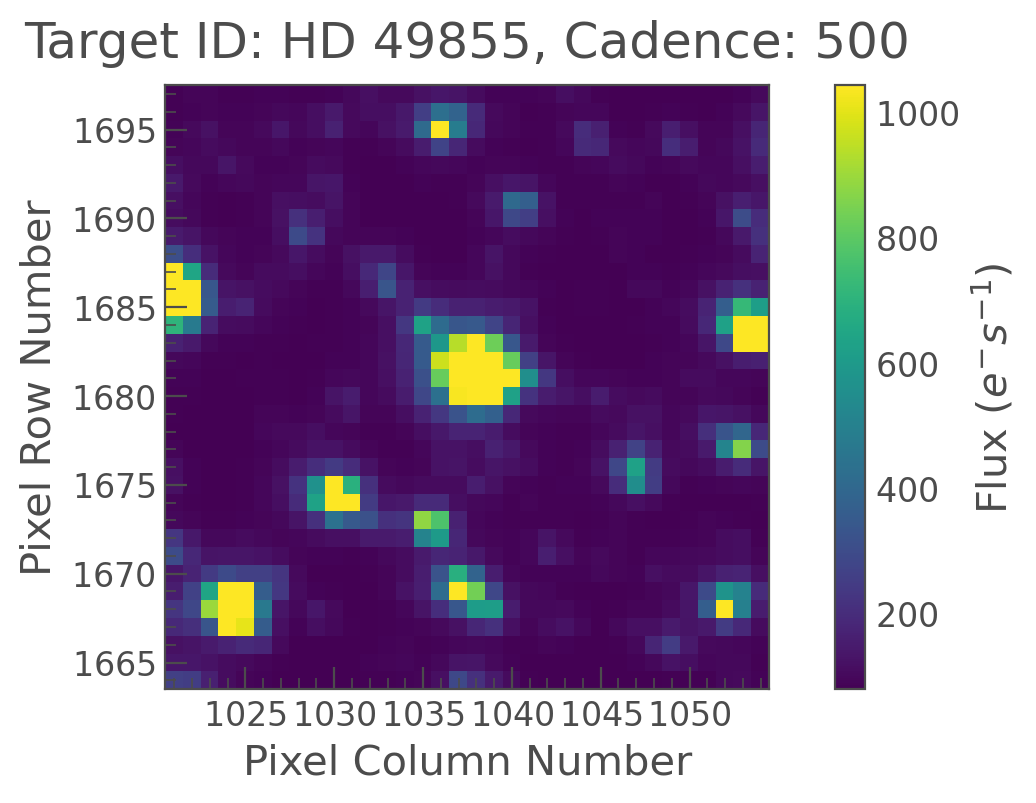

In [27]:
tpf.plot(frame=500)

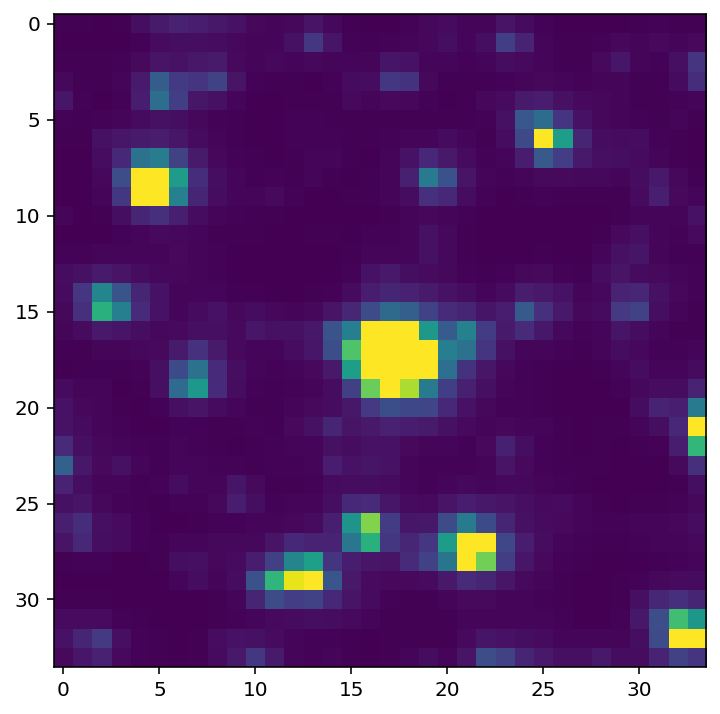

In [28]:
plt.figure(figsize=(6,6))
plt.imshow(median_frame, origin='upper', vmin=lo, vmax=hi)

Ok, good spot-check, we are pointed at the right thing!

In [29]:
vec = np.arange(34)
xx, yy = np.meshgrid(vec, vec)
dist = np.hypot(xx-17, yy-17)

In [30]:
aperture_mask = (median_frame > hi) & (dist < 5)

In [31]:
bkg_mask = (median_frame < mediumlo) & (dist > 9)

In [32]:
n_ap = np.sum(aperture_mask)

In [33]:
n_bkg = np.sum(bkg_mask)

In [34]:
flux = np.sum(datacube*aperture_mask, axis=(1,2)) - np.sum(datacube*bkg_mask, axis=(1,2))/n_bkg*n_ap

In [35]:
lc_tica = lk.LightCurve(time=times, flux=flux).normalize().remove_outliers()

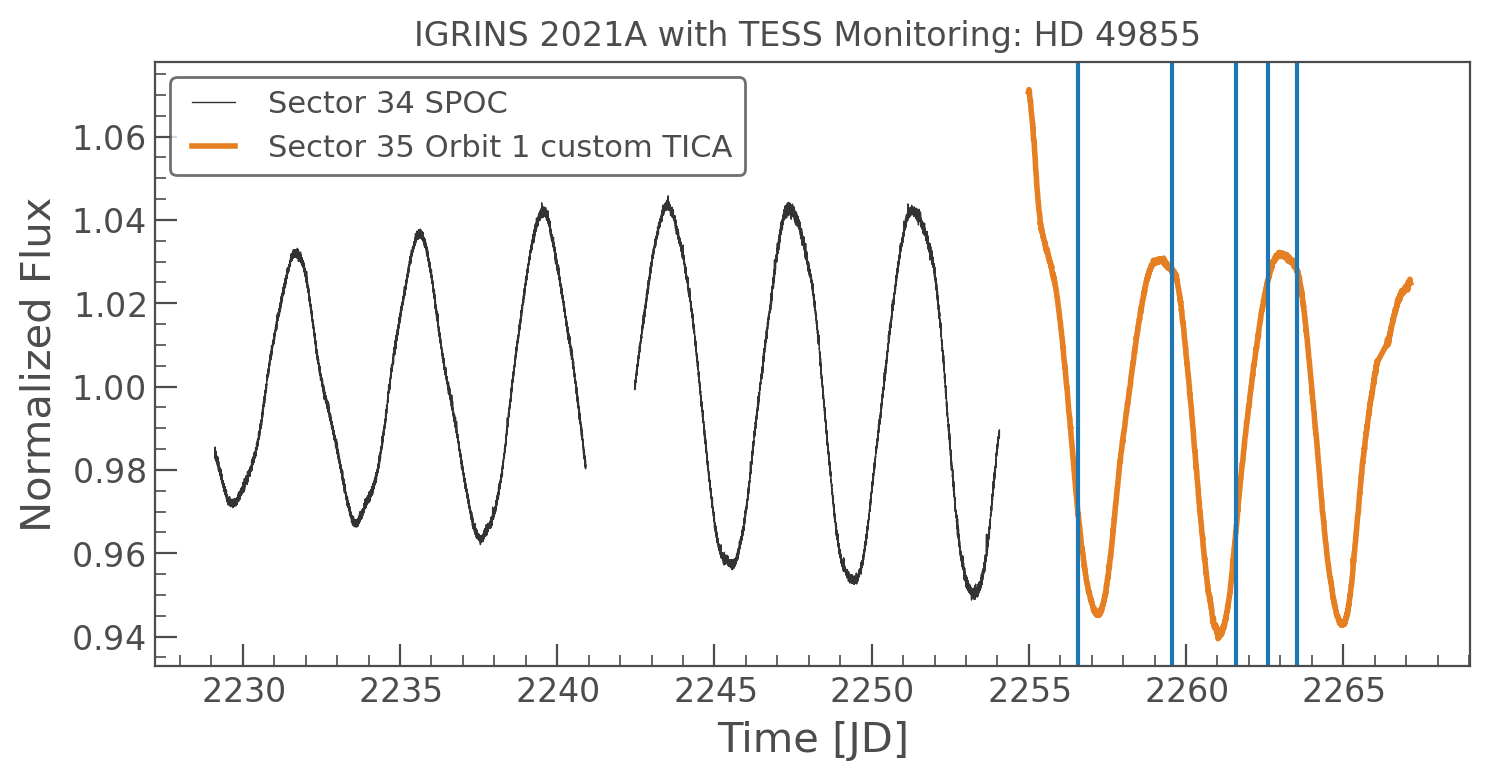

In [36]:
object_name = 'HD 49855'
sr = lk.search_lightcurve(object_name, sector='34', exptime=120)
lc = sr.download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot(label='Sector 34 SPOC');

lc_tica.plot(ax=ax, label = 'Sector 35 Orbit 1 custom TICA', color='#e67e22', lw=2);

for epoch in epochs:
    ax.axvline(epoch)
    
plt.title(f"IGRINS 2021A with TESS Monitoring: {object_name} ")
    
plt.savefig('../../results/plots/HD_49855_TESS_TICA_S35_IGRINS.png',
           dpi=300, bbox_inches='tight')

Neat! We achieved our goal!  We see that we sampled at least a high and low phase, so that's a win.